In [313]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [314]:
# Constants given by the problem
n = 10  # number of segments
beta = 0.5  # design input parameter
L = 2 * np.pi  # assuming L is one wavelength of the sinusoidal wave

# (14) Calculate the lengths of the curved segments c and the straight segments l
c = L / n * beta
l = L / n * (1 - beta)

In [315]:
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.misc import derivative
import numdifftools as nd
from numpy import cos, sin

In [316]:
import numpy as np
import numdifftools as nd
from scipy.integrate import quad
from scipy.optimize import fsolve

def z(x, L):
    """Sinusoidal centerline curve function."""
    return np.sin(2 * np.pi * x / L)

def dz_dx(x, L):
    """Derivative of z with respect to x."""
    z_wrapped = lambda x: z(x, L)
    derivative = nd.Derivative(z_wrapped)
    return derivative(x)

def arc_length_integral(x, L):
    """Calculate the integral of the arc length from 0 to x."""
    # Use dz_dx directly inside the integral
    result, _ = quad(lambda x_prime: np.sqrt(1 + dz_dx(x_prime, L)**2), 0, x)
    return result

def get_x(s, L):
    """Find x coordinate for a given arc length s."""
    func_to_solve = lambda x: arc_length_integral(x, L) - s
    x_initial_guess = s  # Initial guess for x
    x_solution, = fsolve(func_to_solve, x_initial_guess)
    return x_solution

# Example usage
L = 10  # Example value for L
s = 2   # Example arc length to find x for
x_solution = get_x(s, L)
z_value = z(x_solution, L)  # Calculate z using the original function

print(f"x: {x_solution}, z: {z_value}")


x: 1.7783063920861544, z: 0.8989395965094429


In [325]:
s = [] # sampled arc length, s
s_x = [] # x coordinate for arc length s
pd = [] # homogenous xyz coordinate for arc length s
diff_pd = []

for j in range(n+1):
    sj = j*L/n
    sj_x = get_x(sj, L)
    sj_z = z(sj_x, L)
    pdj = np.array([sj_x, 0, sj_z, 1]) # homogeneous coordinates
    diff_pdj = np.array([dz_dx(sj_x,L), 0, 0, 1])
    # print(dz_dx(sj_x,L))
    # print(-2*np.pi/L*cos(2*np.pi*sj_x/L))

    s.append(sj)
    s_x.append(sj_x)
    pd.append(pdj) 

    diff_pd.append(diff_pdj)

# print(s)
# print(s_x)
print(pd)
# print(diff_pd)
# print(len(diff_pd))

[array([0., 0., 0., 1.]), array([0.45177519, 0.        , 0.43656331, 1.        ]), array([0.95218799, 0.        , 0.81468628, 1.        ]), array([1.54565567, 0.        , 0.99968399, 1.        ]), array([2.14556552, 0.        , 0.8393178 , 1.        ]), array([2.65227732, 0.        , 0.47002167, 1.        ]), array([3.10603091, 0.        , 0.03555425, 1.        ]), array([ 3.55613113,  0.        , -0.40276754,  1.        ]), array([ 4.05061015,  0.        , -0.78890035,  1.        ]), array([ 4.63703026,  0.        , -0.99716187,  1.        ]), array([ 5.2426321 ,  0.        , -0.86268414,  1.        ])]


In [318]:
def T_j(c, l, kj):
    # constant curvatrue bending transformation (Eq 11)
    th_j = kj * l 
    T_b_j = np.array([[cos(th_j), 0, sin(th_j), (1 - cos(th_j)) / kj],
                        [0, 1, 0, 0],
                        [-sin(th_j), 0, cos(th_j), sin(th_j) / kj],
                        [0, 0, 0, 1]
                    ])
    # rigid translation (Eq 12)
    T_r_j = np.array([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 1, c],
                        [0, 0, 0, 1]
                    ])
    T_j = T_r_j @ T_b_j
    return T_j # (Eq13)

def Tb(l, kj):
    th_j = kj * l 
    T_b_j = np.array([[cos(th_j), 0, sin(th_j), (1 - cos(th_j)) / kj],
                        [0, 1, 0, 0],
                        [-sin(th_j), 0, cos(th_j), sin(th_j) / kj],
                        [0, 0, 0, 1]
                    ])
    return T_b_j

def Tr(c):
    Tr_j = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, c],
                    [0, 0, 0, 1]
                    ])
    return Tr_j


In [328]:

    
def error_function(diff_pdj, pdj, pj_1, c, l, kj):
    # normal vector -> error direction
    Ry_90 = np.array([[0, 0, 1, 0], 
                      [0, 1, 0, 0], 
                      [-1, 0, 0, 0],
                      [0, 0, 0, 1]])
    Nj = Ry_90 @ diff_pdj
    # print(f"Nj shape: {Nj.shape}, diff_pd shape: {diff_pd.shape}") 
    
    # error evector
    pj = T_j(c,l,kj) @ pj_1
    # pj = Tr(c) @ Tb(l,kj) @ pj_1
    ej_vec = pj - pdj
    # print(f"pj shape: {pj.shape}, ej_vec shape: {ej_vec.shape}") 

    # error scalar
    ej = Nj.T @ ej_vec
    print(ej)
    return ej

def p_update(c, l, kj, pj_1):
    pj = T_j(c,l,kj) @ pj_1
    # pj = Tr(c) @ Tb(l,kj) @ pj_1
    return pj

# Optimization loop
p = []
k = []

def error_func_wrapper(diff_pdj, pdj, pj_1, c, l, kj_array):
        # Call error_function with kj_array[0] to treat it as a scalar
        return error_function(diff_pdj, pdj, pj_1, c, l, kj_array[0])

for j in range(1, n + 1):

    kj_i_arr = np.array([1/L])  # initial guess for segment curvature

    if j-1 == 0:
        p.append(np.array([0, 0, 0, 1])) # initial p[0]
    error_func = lambda kj: error_func_wrapper(diff_pd[j], pd[j], p[j-1], c, l, kj)
     
    kj_sol, = fsolve(error_func, kj_i_arr, xtol=1e-12, maxfev=1000)

    # Store the solution
    k.append(kj_sol)
    # Update pj for the next iteration
    p.append(p_update(c, l, kj_sol, p[j-1]))
    print(f"Segment {j}, Curvature: {kj_sol}")

print(f"solved kj:{k}, Optimized p:{p}")

-0.1723993417450839
-0.1723993417450839
-0.1723993417450839
-0.1723993417415751
0.16293265945610552
0.05643792820830666
-0.0959347561242964
-0.0006720186732743005
1.9000579905094333e-05
1.8299332486501235e-09
-5.094075203647972e-15
0.0
Segment 1, Curvature: 6.840966842395868
-0.13814394708465286
-0.13814394708465286
-0.13814394708465286
-0.13814394697540297
0.10782362587527171
-0.02204122077049891
-0.0017914857135573439
4.294519598840504e-05
-7.670405805947459e-08
-3.2617234008505278e-12
-6.438204967925719e-17
6.438204967925719e-17
-6.438204967925719e-17
2.893503981086598e-09
6.438204967925719e-17
-6.438204967925719e-17
-2.0177334369479202e-13
6.438204967925719e-17
Segment 2, Curvature: 2.0857933351153766
-0.010431107678009439
-0.010431107678009439
-0.010431107678009439
-0.01043110766696177
0.004491991948763956
-0.0007726210264724198
-3.081009605785089e-05
2.590474961684827e-07
-8.367446977803301e-11
-2.288521056988235e-16
0.0
Segment 3, Curvature: 1.8273540470028171
0.4011816005480768

11 10


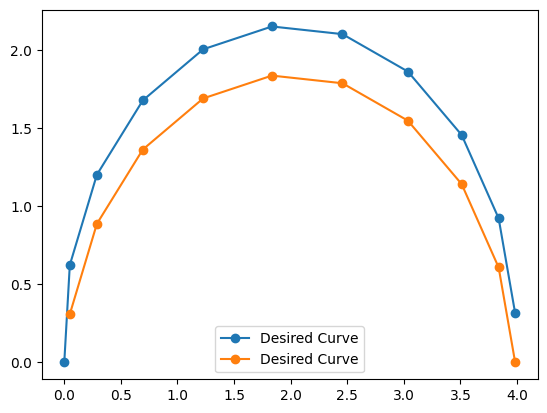

In [338]:
# test k
k_test = np.array([3,3,3,3,3,3,3,3,3,3,3])
p_test =[]
p_test_notched = [] 
for i in range(1,len(k)+1):
    if i-1==0:
        p_test.append(np.array([0,0,0,1]))
    T = Tr(c) @ Tb(l,k_test[i]/3) @ p_test[i-1]
    p_test_notched.append(Tb(l,k_test[i]/3) @ p_test[i-1])
    p_test.append(T)
print(len(p_test),len(p_test_notched))

p_x = []
p_z = []
p_notch_x=[]
p_notch_z=[]
for i in range(len(p_test)):
    p_x.append(p_test[i][0])
    p_z.append(p_test[i][2])
for i in range(len(p_test_notched)):
    p_notch_x.append(p_test_notched[i][0])
    p_notch_z.append(p_test_notched[i][2])
plt.plot(p_x, p_z, marker='o', linestyle='-', label='Desired Curve')
plt.plot(p_notch_x, p_notch_z, marker='o', linestyle='-', label='Desired Curve')
plt.legend()
plt.show()

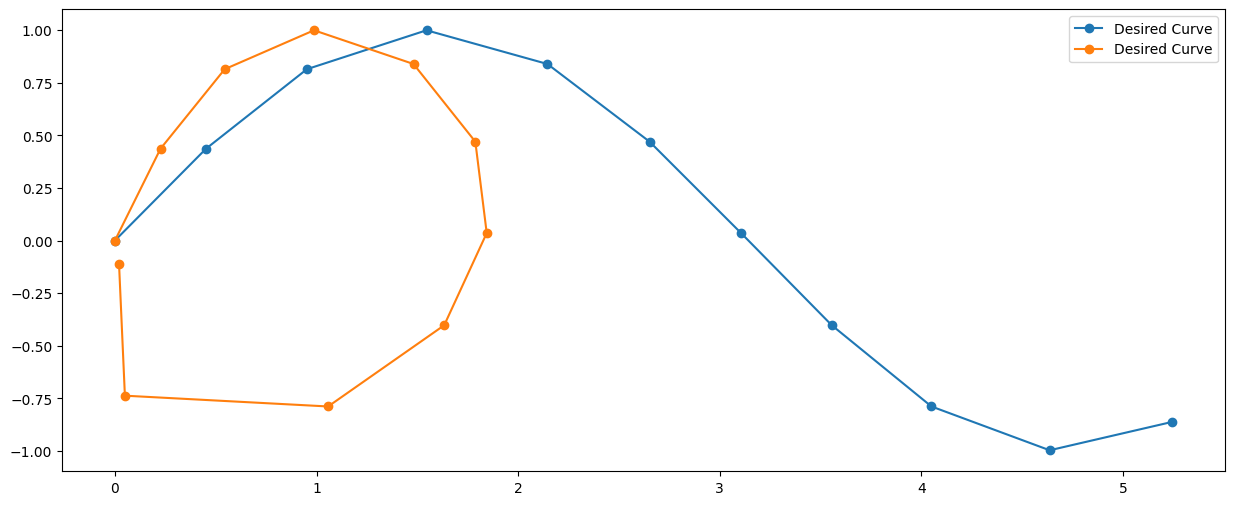

In [335]:
p_x = []
p_z = []
pd_x = []
pd_z = []

for i in range(len(pd)):
    p_x.append(p[i][0])
    p_z.append(p[i][2])
    pd_x.append(pd[i][0])
    pd_z.append(pd[i][2])

# print(p_x)
# print(p_z)
plt.figure(figsize=(15, 6))
plt.plot(pd_x, pd_z, marker='o', linestyle='-', label='Desired Curve')
plt.plot(p_x, p_z, marker='o', linestyle='-', label='Desired Curve')
plt.legend()
plt.show()


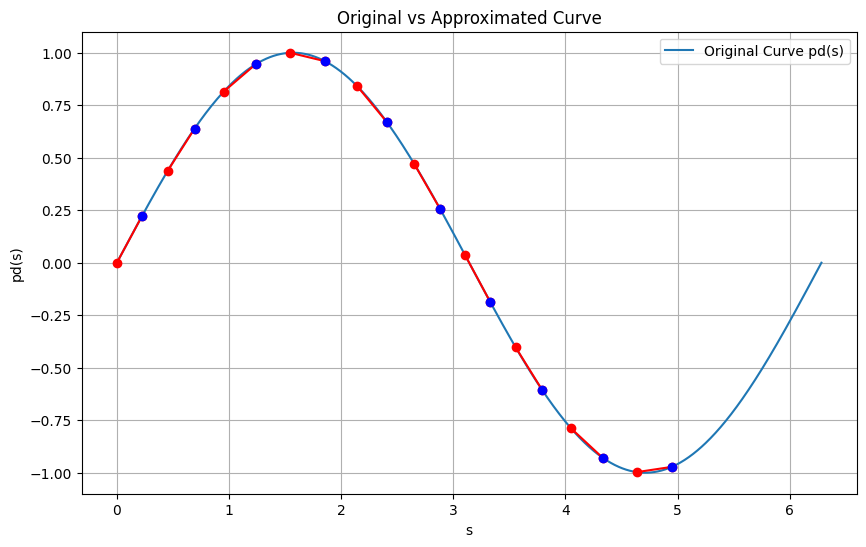

(0.3141592653589793,
 0.3141592653589793,
 array([0.15915494, 0.15915494, 0.15915494, 0.15915494, 0.15915494,
        0.15915494, 0.15915494, 0.15915494, 0.15915494, 0.15915494]))

In [346]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Constants given by the problem
n = 10  # number of segments
beta = 0.5  # design input parameter
L = 2 * np.pi  # assuming L is one wavelength of the sinusoidal wave

# Calculate the lengths of the curved segments c and the straight segments l
c = L / n * beta
l = L / n * (1 - beta)

# Define the sinusoidal centerline curve pd(s)
def z(s, L):
    return np.sin(2 * np.pi * s / L)


# Plotting the original and the approximated curve
s_fine = np.linspace(0, L, 1000)
pd_fine = z(s_fine, L)

plt.figure(figsize=(10, 6))
plt.plot(s_fine, pd_fine, label='Original Curve pd(s)')

# Plot the approximated curve using straight and curved segments
for j in range(n):
    sj = s_values[j]
    # get_x(sj)
    # plt.plot([sj, sj + l], [z(sj, L), z(sj + l, L)], 'ro-')  # Straight segment
    plt.plot([get_x(sj,L), get_x(sj+l,L)], [z(get_x(sj,L), L), z(get_x(sj+l,L), L)], 'ro-')  # Straight segment

    # For curved segment, we'll just plot a point for simplicity, as we don't have
    # the actual function for the curved segment shape
    plt.plot(get_x(sj+l,L), z(get_x(sj+l,L), L), 'bo')  # Curved segment midpoint

plt.xlabel('s')
plt.ylabel('pd(s)')
plt.title('Desired vs Approximated Curve')
plt.legend()
plt.grid(True)
plt.show()

# Output the calculated lengths and curvatures
c, l, k_values
